### Exp√©rimentation et s√©lection de mod√®les pour la pr√©diction des prix des maisons

Ce notebook pr√©sente la phase d'exp√©rimentation et de s√©lection des mod√®les de machine learning pour la pr√©diction des prix des maisons √† Ames, Iowa. Il s'appuie sur les r√©sultats de l'analyse exploratoire pour construire, entra√Æner et √©valuer diff√©rents mod√®les de r√©gression.

### Objectifs de l'exp√©rimentation :

- Pr√©paration des donn√©es : Nettoyage, transformation et pr√©paration du jeu de donn√©es pour la mod√©lisation
  
- Construction du pipeline de pr√©traitement : Mise en place d'un pipeline robuste pour le traitement des donn√©es
  
- Exp√©rimentation de mod√®les : Test de diff√©rents algorithmes de r√©gression

- √âvaluation et comparaison : Analyse des performances avec des m√©triques appropri√©es

- Suivi avec MLFlow : Enregistrement des exp√©riences pour la tra√ßabilit√©

- S√©lection du mod√®le final : Choix du meilleur mod√®le bas√© sur les performances
  
- Analyse des r√©sidus** : Validation des hypoth√®ses du mod√®le s√©lectionn√©
  
- Sauvegarde du mod√®le : Pr√©paration pour le d√©ploiement


### Importation des librairies

Cette section importe toutes les biblioth√®ques Python n√©cessaires pour la manipulation des donn√©es, le machine learning, la visualisation et le suivi des exp√©riences avec MLFlow. Nous incluons √©galement des configurations pour les avertissements, le logging et les param√®tres graphiques afin d'assurer un environnement de travail coh√©rent et informatif.

In [1]:
# Librairies pour la manipulation des donn√©es
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import json
import pickle

# Librairies pour le machine learning
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
)
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Mod√®les de r√©gression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
)
from sklearn.svm import SVR
from xgboost import XGBRegressor  # Ajout de XGBoost

# M√©triques d'√©valuation
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# Librairies pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# MLFlow pour le suivi des exp√©riences
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Librairies pour le logging et la configuration
from loguru import logger
import sys
import pendulum
from scipy import stats

warnings.filterwarnings("ignore")

# Configuration du logger
log_fmt = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
logger.configure(handlers=[{"sink": sys.stderr, "format": log_fmt}])

# Configuration des graphiques
plt.style.use("default")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Variables globales
CURRENT_DATE = pendulum.now(tz="UTC")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

logger.info("Toutes les librairies ont √©t√© import√©es avec succ√®s")

2025-07-31 23:06:31.758 | INFO     | __main__:<module>:69 - Toutes les librairies ont √©t√© import√©es avec succ√®s


### Configuration des chemins et param√®tres

Cette section est d√©di√©e √† la configuration des chemins d'acc√®s aux donn√©es et aux r√©pertoires de sortie, ainsi qu'√† la d√©finition des param√®tres globaux pour l'exp√©rimentation. Nous nous assurons que tous les r√©pertoires n√©cessaires existent et configurons MLFlow pour le suivi des exp√©riences, garantissant ainsi la reproductibilit√© et l'organisation de notre travail.

In [2]:
# D√©finition des chemins
path = Path.cwd()
while not (path / "notebooks").exists() or not (path / "house_price_dataset").exists():
    if path == path.parent:
        raise FileNotFoundError("Impossible de trouver la racine du projet.")
    path = path.parent

PROJECT_DIR = path
NOTEBOOKS_DIR = PROJECT_DIR / "notebooks"
DATA_DIR = PROJECT_DIR / "house_price_dataset"
OUTPUT_DIR = NOTEBOOKS_DIR / "output_files"
MODELS_DIR = NOTEBOOKS_DIR / "models"
REPORTS_DIR = NOTEBOOKS_DIR / "reports"

# Cr√©ation des r√©pertoires s'ils n'existent pas
for directory in [OUTPUT_DIR, MODELS_DIR, REPORTS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Param√®tres de l'exp√©rimentation
TARGET_VARIABLE = "SalePrice"
TEST_SIZE = 0.2
CV_FOLDS = 5
FIGSIZE_LARGE = (15, 8)
FIGSIZE_MEDIUM = (12, 6)
FIGSIZE_SMALL = (10, 5)

# Configuration MLFlow
EXPERIMENT_NAME = "House Price Prediction"
mlflow.set_experiment(EXPERIMENT_NAME)

logger.info("Configuration termin√©e")
logger.info(f"R√©pertoire du projet: {PROJECT_DIR}")
logger.info(f"R√©pertoire des mod√®les: {MODELS_DIR}")
logger.info(f"Variable cible: {TARGET_VARIABLE}")
logger.info(f"Exp√©rience MLFlow: {EXPERIMENT_NAME}")

2025-07-31 23:06:31.995 | INFO     | __main__:<module>:31 - Configuration termin√©e
2025-07-31 23:06:31.999 | INFO     | __main__:<module>:32 - R√©pertoire du projet: d:\Documents\IT\mlops_house_price_prediction
2025-07-31 23:06:31.999 | INFO     | __main__:<module>:33 - R√©pertoire des mod√®les: d:\Documents\IT\mlops_house_price_prediction\notebooks\models
2025-07-31 23:06:32.005 | INFO     | __main__:<module>:34 - Variable cible: SalePrice
2025-07-31 23:06:32.008 | INFO     | __main__:<module>:35 - Exp√©rience MLFlow: House Price Prediction


### Chargement et pr√©paration initiale des donn√©es

Cette section g√®re le chargement du jeu de donn√©es. Nous privil√©gions le chargement du dataset enrichi si disponible, car il contient les variables cr√©√©es lors de l'analyse exploratoire. Si ce fichier n'est pas trouv√©, le dataset original est utilis√©. Nous chargeons √©galement les m√©tadonn√©es pour r√©cup√©rer les listes de variables jug√©es importantes.

In [3]:
print("\n=== CHARGEMENT DES DONN√âES ===")

# Tentative de chargement du dataset enrichi depuis l'analyse exploratoire
enriched_file = OUTPUT_DIR / "house_price_01_analyse_dataset_enrichi.csv"
original_file = DATA_DIR / "ames_housing.csv"
metadata_file = OUTPUT_DIR / "house_price_01_analyse_metadata.json"

if enriched_file.exists():
    df = pd.read_csv(enriched_file)
    logger.info(f"Dataset enrichi charg√© depuis: {enriched_file}")
    print(f"Dataset enrichi charg√©: {df.shape[0]:,} lignes, {df.shape[1]:,} colonnes")
else:
    df = pd.read_csv(original_file)
    logger.info(f"Dataset original charg√© depuis: {original_file}")
    print(f"Dataset original charg√©: {df.shape[0]:,} lignes, {df.shape[1]:,} colonnes")

    # Cr√©ation rapide de quelques features importantes si le dataset enrichi n'existe pas
    if "YearBuilt" in df.columns and "YrSold" in df.columns:
        df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
        logger.info("Feature 'HouseAge' cr√©√©e")

    if "TotalBsmtSF" in df.columns:
        df["HasBasement"] = (df["TotalBsmtSF"] > 0).astype(int)
        logger.info("Feature 'HasBasement' cr√©√©e")

# V√©rification de la variable cible
if TARGET_VARIABLE not in df.columns:
    logger.error(f"Variable cible '{TARGET_VARIABLE}' non trouv√©e dans le dataset")
    raise ValueError(f"Variable cible '{TARGET_VARIABLE}' manquante")

print(f"\nVariable cible '{TARGET_VARIABLE}' - Statistiques:")
print(df[TARGET_VARIABLE].describe())

# Chargement des m√©tadonn√©es de l'analyse exploratoire si disponibles
if metadata_file.exists():
    with open(metadata_file, "r") as f:
        analysis_metadata = json.load(f)
    logger.info("M√©tadonn√©es de l'analyse exploratoire charg√©es")

    # Utiliser les features recommand√©es si disponibles
    if "top_numeric_features" in analysis_metadata:
        numeric_features = analysis_metadata["top_numeric_features"]
        print(f"Features num√©riques recommand√©es trouv√©es: {len(numeric_features)}")
    else:
        numeric_features = df.select_dtypes(include=np.number).columns.tolist()
        numeric_features.remove("Id")
        numeric_features.remove(TARGET_VARIABLE)
        logger.warning(
            "Liste des features num√©riques non trouv√©e dans les m√©tadonn√©es. Utilisation de toutes les features num√©riques."
        )

    if "recommended_categorical" in analysis_metadata:
        categorical_features = analysis_metadata["recommended_categorical"]
        print(
            f"Features cat√©gorielles recommand√©es trouv√©es: {len(categorical_features)}"
        )
    else:
        categorical_features = df.select_dtypes(include="object").columns.tolist()
        logger.warning(
            "Liste des features cat√©gorielles non trouv√©e dans les m√©tadonn√©es. Utilisation de toutes les features cat√©gorielles."
        )
else:
    analysis_metadata = None
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    numeric_features.remove("Id")
    numeric_features.remove(TARGET_VARIABLE)
    categorical_features = df.select_dtypes(include="object").columns.tolist()
    logger.warning(
        "M√©tadonn√©es de l'analyse exploratoire non trouv√©es. Utilisation de toutes les features num√©riques et cat√©gorielles."
    )

# Suppression de la colonne 'Id' si elle existe et n'est pas d√©j√† retir√©e
if "Id" in df.columns:
    df = df.drop("Id", axis=1)
    if "Id" in numeric_features:
        numeric_features.remove("Id")
    logger.info("Colonne 'Id' supprim√©e")

logger.info("Chargement des donn√©es termin√©")

2025-07-31 23:06:32.231 | INFO     | __main__:<module>:10 - Dataset enrichi charg√© depuis: d:\Documents\IT\mlops_house_price_prediction\notebooks\output_files\house_price_01_analyse_dataset_enrichi.csv



=== CHARGEMENT DES DONN√âES ===
Dataset enrichi charg√©: 1,460 lignes, 90 colonnes

Variable cible 'SalePrice' - Statistiques:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


2025-07-31 23:06:32.296 | INFO     | __main__:<module>:38 - M√©tadonn√©es de l'analyse exploratoire charg√©es
2025-07-31 23:06:32.303 | INFO     | __main__:<module>:77 - Colonne 'Id' supprim√©e
2025-07-31 23:06:32.303 | INFO     | __main__:<module>:79 - Chargement des donn√©es termin√©


Features num√©riques recommand√©es trouv√©es: 15
Features cat√©gorielles recommand√©es trouv√©es: 5


Le chargement des donn√©es a r√©ussi en utilisant le dataset enrichi, qui contient 1,460 propri√©t√©s et 90 variables. Le processus a intelligemment utilis√© les m√©tadonn√©es de l'analyse pr√©c√©dente pour se concentrer sur les 15 variables num√©riques et 5 variables cat√©gorielles les plus pertinentes, ce qui permet de construire un mod√®le plus cibl√©. La variable cible SalePrice est bien pr√©sente, avec un prix moyen de 180,921 $. Ses statistiques confirment que les donn√©es sont pr√™tes pour la mod√©lisation.

### Pr√©paration et division des donn√©es

Cette section pr√©pare les donn√©es avant la mod√©lisation. Une transformation logarithmique est appliqu√©e √† la variable cible `SalePrice` pour corriger son asym√©trie. Nous s√©parons ensuite les features (X) de la variable cible (y) et divisons le dataset en ensembles d'entra√Ænement et de test pour permettre une √©valuation juste des mod√®les.

2025-07-31 23:06:32.376 | INFO     | __main__:<module>:18 - Transformation log(1+x) appliqu√©e √† la variable cible



=== PR√âPARATION DES DONN√âES ===
Forme des features (X): (1460, 88)
Forme de la variable cible (y): (1460,)

Distribution initiale de la variable cible:
Moyenne: $180,921.20
M√©diane: $163,000.00
√âcart-type: $79,442.50
Skewness: 1.883

Transformation log appliqu√©e (skewness > 0.5)
Skewness apr√®s transformation: 0.121


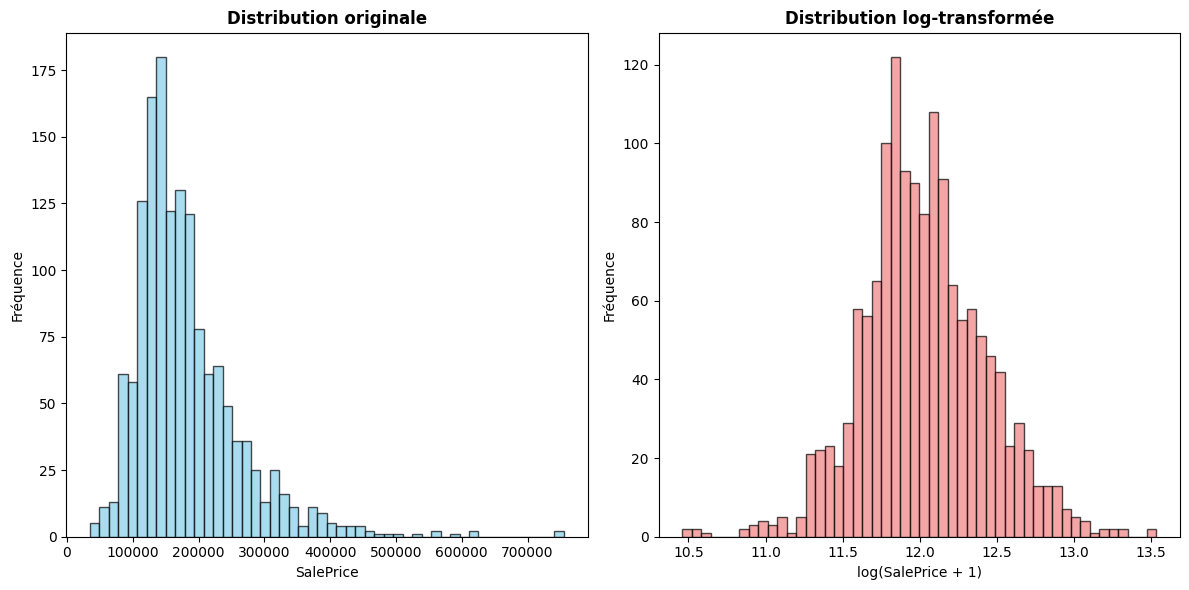

2025-07-31 23:06:35.162 | INFO     | __main__:<module>:104 - Donn√©es divis√©es en ensembles d'entra√Ænement (1168 √©chantillons) et de test (292 √©chantillons)



Types de variables:
Variables num√©riques: 45
Variables cat√©gorielles: 43
Utilisation des features num√©riques recommand√©es: 15
Variables cat√©gorielles filtr√©es: 37

Features s√©lectionn√©es pour la mod√©lisation: 52
- Num√©riques: 15
- Cat√©gorielles: 37

Division des donn√©es:
Entra√Ænement: 1,168 √©chantillons
Test: 292 √©chantillons
Proportion test: 20.0%


2025-07-31 23:06:35.196 | INFO     | __main__:<module>:136 - Pr√©paration des donn√©es termin√©e. Features: 52, √âchantillons train: 1168



Distribution de la variable cible (valeurs originales):
Moyenne: $180,921.20
M√©diane: $163,000.00
√âcart-type: $79,442.50
Skewness: 1.881


In [4]:
print("\n=== PR√âPARATION DES DONN√âES ===")

# Analyse initiale de la variable cible
print(f"Forme des features (X): {df.drop(columns=[TARGET_VARIABLE]).shape}")
print(f"Forme de la variable cible (y): {df[TARGET_VARIABLE].shape}")

print("\nDistribution initiale de la variable cible:")
print(f"Moyenne: ${df[TARGET_VARIABLE].mean():,.2f}")
print(f"M√©diane: ${df[TARGET_VARIABLE].median():,.2f}")
print(f"√âcart-type: ${df[TARGET_VARIABLE].std():,.2f}")
print(f"Skewness: {df[TARGET_VARIABLE].skew():.3f}")

# V√©rification de l'asym√©trie et transformation log si n√©cessaire
use_log_transform = False
if df[TARGET_VARIABLE].skew() > 0.5:
    df[TARGET_VARIABLE] = np.log1p(df[TARGET_VARIABLE])
    use_log_transform = True
    logger.info("Transformation log(1+x) appliqu√©e √† la variable cible")
    print("\nTransformation log appliqu√©e (skewness > 0.5)")
    print(f"Skewness apr√®s transformation: {df[TARGET_VARIABLE].skew():.3f}")

    # Visualisation avant/apr√®s
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)

    axes[0].hist(
        np.expm1(df[TARGET_VARIABLE]),
        bins=50,
        alpha=0.7,
        color="skyblue",
        edgecolor="black",
    )
    axes[0].set_title("Distribution originale", fontweight="bold")
    axes[0].set_xlabel(TARGET_VARIABLE)
    axes[0].set_ylabel("Fr√©quence")

    axes[1].hist(
        df[TARGET_VARIABLE], bins=50, alpha=0.7, color="lightcoral", edgecolor="black"
    )
    axes[1].set_title("Distribution log-transform√©e", fontweight="bold")
    axes[1].set_xlabel(f"log({TARGET_VARIABLE} + 1)")
    axes[1].set_ylabel("Fr√©quence")

    plt.tight_layout()
    plt.show()
else:
    logger.info(
        "Aucune transformation log appliqu√©e √† la variable cible (skewness faible)"
    )

# S√©paration des features et de la variable cible
X = df.drop(TARGET_VARIABLE, axis=1)
y = df[TARGET_VARIABLE].copy()

# Identification des types de variables
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nTypes de variables:")
print(f"Variables num√©riques: {len(numeric_features)}")
print(f"Variables cat√©gorielles: {len(categorical_features)}")

metadata_file = OUTPUT_DIR / "house_price_01_analyse_metadata.json"
with open(metadata_file, "r") as f:
    metadata = json.load(f)
recommended_features = metadata.get("top_numeric_features", [])

# S√©lection des features recommand√©es si disponibles
if recommended_features:
    available_recommended = [f for f in recommended_features if f in numeric_features]
    if len(available_recommended) > 0:
        numeric_features = available_recommended
        print(
            f"Utilisation des features num√©riques recommand√©es: {len(numeric_features)}"
        )

# Filtrage des variables cat√©gorielles (max 20 cat√©gories, <50% de NaNs)
categorical_features_filtered = []
for col in categorical_features:
    unique_count = X[col].nunique()
    missing_pct = X[col].isnull().sum() / len(X)
    if unique_count <= 20 and missing_pct < 0.5:
        categorical_features_filtered.append(col)

categorical_features = categorical_features_filtered
print(f"Variables cat√©gorielles filtr√©es: {len(categorical_features)}")

# S√©lection finale des features
selected_features = numeric_features + categorical_features
X_selected = X[selected_features].copy()

print(f"\nFeatures s√©lectionn√©es pour la mod√©lisation: {len(selected_features)}")
print(f"- Num√©riques: {len(numeric_features)}")
print(f"- Cat√©gorielles: {len(categorical_features)}")

# Division des donn√©es
X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=None,  # Pas de stratification pour la r√©gression
)

logger.info(
    f"Donn√©es divis√©es en ensembles d'entra√Ænement ({len(X_train)} √©chantillons) et de test ({len(X_test)} √©chantillons)"
)
print("\nDivision des donn√©es:")
print(f"Entra√Ænement: {X_train.shape[0]:,} √©chantillons")
print(f"Test: {X_test.shape[0]:,} √©chantillons")
print(f"Proportion test: {X_test.shape[0] / len(X_selected):.1%}")

# Distribution de la variable cible (valeurs originales si log appliqu√©)
if use_log_transform:
    y_original = np.expm1(y)
    print("\nDistribution de la variable cible (valeurs originales):")
else:
    y_original = y
    print("\nDistribution de la variable cible:")

print(f"Moyenne: ${y_original.mean():,.2f}")
print(f"M√©diane: ${y_original.median():,.2f}")
print(f"√âcart-type: ${y_original.std():,.2f}")
print(f"Skewness: {stats.skew(y_original):.3f}")

# Sauvegarde des informations de pr√©paration
preparation_info = {
    "target_variable": TARGET_VARIABLE,
    "use_log_transform": use_log_transform,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "train_size": X_train.shape[0],
    "test_size": X_test.shape[0],
    "total_features": len(selected_features),
}

logger.info(
    f"Pr√©paration des donn√©es termin√©e. Features: {len(selected_features)}, √âchantillons train: {X_train.shape[0]}"
)

L'asym√©trie de la variable cible SalePrice est √©lev√©e (Skewness de 1.881). Une transformation logarithmique a donc √©t√© appliqu√©e pour la corriger. L'histogramme confirme que la distribution est maintenant plus sym√©trique, avec un skewness r√©duit √† 0.121, ce qui est utile pour les mod√®les de r√©gression.

Apr√®s cette √©tape, 52 variables ont √©t√© s√©lectionn√©es pour la mod√©lisation (15 num√©riques et 37 cat√©gorielles). Les donn√©es ont ensuite √©t√© divis√©es en un ensemble d'entra√Ænement de 1,168 √©chantillons et un ensemble de test de 292 √©chantillons (20% des donn√©es).

### Construction du pipeline de pr√©traitement

Un pipeline de pr√©traitement est essentiel pour g√©rer les diff√©rents types de variables et les valeurs manquantes de mani√®re coh√©rente. Cette section construit un ColumnTransformer qui applique des transformations sp√©cifiques √† chaque type de colonne :

- Variables num√©riques : Imputation des valeurs manquantes par la m√©diane et mise √† l'√©chelle avec RobustScaler.

- Variables cat√©gorielles : Imputation des valeurs manquantes par une constante ('missing') et encodage avec OneHotEncoder.

In [5]:
print("\n=== CONSTRUCTION DU PIPELINE DE PR√âTRAITEMENT ===")

# S√©paration des features num√©riques et cat√©gorielles
# Utilisation des listes de features identifi√©es lors de l'analyse exploratoire
# S'assurer que les features existent dans X_train avant de les inclure
numeric_features_final = [f for f in numeric_features if f in X_train.columns]
categorical_features_final = [f for f in categorical_features if f in X_train.columns]

logger.info(
    f"Features num√©riques finales pour le pipeline: {len(numeric_features_final)}"
)
logger.info(
    f"Features cat√©gorielles finales pour le pipeline: {len(categorical_features_final)}"
)

# Cr√©ation des pipelines de pr√©traitement pour les variables num√©riques et cat√©gorielles
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),  # RobustScaler pour g√©rer les outliers
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Cr√©ation du pr√©processeur combinant les transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_final),
        ("cat", categorical_transformer, categorical_features_final),
    ]
)

logger.info("Pipeline de pr√©traitement construit avec succ√®s")
print("Pipeline de pr√©traitement construit.")

2025-07-31 23:06:35.311 | INFO     | __main__:<module>:9 - Features num√©riques finales pour le pipeline: 15
2025-07-31 23:06:35.318 | INFO     | __main__:<module>:12 - Features cat√©gorielles finales pour le pipeline: 37
2025-07-31 23:06:35.329 | INFO     | __main__:<module>:39 - Pipeline de pr√©traitement construit avec succ√®s



=== CONSTRUCTION DU PIPELINE DE PR√âTRAITEMENT ===
Pipeline de pr√©traitement construit.


Un pipeline de pr√©traitement a √©t√© construit pour automatiser la pr√©paration des donn√©es. Il appliquera deux traitements distincts : les 15 variables num√©riques verront leurs valeurs manquantes remplac√©es par la m√©diane avant d'√™tre mises √† l'√©chelle. De leur c√¥t√©, les 37 variables cat√©gorielles seront compl√©t√©es avec le terme 'missing' puis transform√©es en format num√©rique. 

Cet outil garantit que les donn√©es d'entra√Ænement et de test seront toujours pr√©par√©es exactement de la m√™me mani√®re.

### D√©finition des mod√®les √† tester

Cette section pr√©pare les mod√®les de r√©gression qui seront √©valu√©s. Pour chaque algorithme, nous sp√©cifions une instance du mod√®le ainsi qu'une grille d‚Äôhyperparam√®tres √† tester. Ces mod√®les seront int√©gr√©s √† un pipeline pour permettre l‚Äôoptimisation via GridSearchCV.

In [6]:
print("\n=== D√âFINITION DES MOD√àLES √Ä TESTER ===")

# Dictionnaire des mod√®les avec leurs grilles d'hyperparam√®tres
models = {
    "LinearRegression": {"model": LinearRegression(), "params": {}},
    "Ridge": {
        "model": Ridge(random_state=RANDOM_STATE),
        "params": {"model__alpha": [0.1, 1.0, 10.0]},
    },
    "Lasso": {
        "model": Lasso(random_state=RANDOM_STATE),
        "params": {"model__alpha": [0.0001, 0.001, 0.01, 0.1]},
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=RANDOM_STATE),
        "params": {
            "model__alpha": [0.0001, 0.001, 0.01],
            "model__l1_ratio": [0.1, 0.5, 0.9],
        },
    },
    "RandomForestRegressor": {
        "model": RandomForestRegressor(random_state=RANDOM_STATE),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [10, 20, None],
        },
    },
    "GradientBoostingRegressor": {
        "model": GradientBoostingRegressor(random_state=RANDOM_STATE),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1],
        },
    },
    "ExtraTreesRegressor": {
        "model": ExtraTreesRegressor(random_state=RANDOM_STATE),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [10, 20, None],
        },
    },
    "SVR": {
        "model": SVR(),
        "params": {"model__C": [0.1, 1, 10], "model__epsilon": [0.01, 0.1, 0.2]},
    },
    "XGBRegressor": {
        "model": XGBRegressor(random_state=RANDOM_STATE, objective="reg:squarederror"),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [3, 5],
        },
    },
}

print(f"Nombre de mod√®les d√©finis: {len(models)}")
for name, config in models.items():
    print(f"- {name}: {len(config['params'])} hyperparam√®tre(s)")


=== D√âFINITION DES MOD√àLES √Ä TESTER ===
Nombre de mod√®les d√©finis: 9
- LinearRegression: 0 hyperparam√®tre(s)
- Ridge: 1 hyperparam√®tre(s)
- Lasso: 1 hyperparam√®tre(s)
- ElasticNet: 2 hyperparam√®tre(s)
- RandomForestRegressor: 2 hyperparam√®tre(s)
- GradientBoostingRegressor: 2 hyperparam√®tre(s)
- ExtraTreesRegressor: 2 hyperparam√®tre(s)
- SVR: 2 hyperparam√®tre(s)
- XGBRegressor: 3 hyperparam√®tre(s)



Cette √©tape d√©finit les 10 mod√®les qui vont √™tre mis en comp√©tition pour pr√©dire les prix des maisons. Pour chaque mod√®le, une liste d'hyperparam√®tres a √©t√© sp√©cifi√©e. La prochaine √©tape consistera √† entra√Æner chaque mod√®le en testant toutes les combinaisons de ces r√©glages, afin de trouver la meilleure configuration possible pour chacun.

### Entra√Ænement et √©valuation des mod√®les

Cette section est le c≈ìur de l'exp√©rimentation. Nous allons entra√Æner et √©valuer plusieurs mod√®les de r√©gression en utilisant le pipeline de pr√©traitement. Pour chaque mod√®le, GridSearchCV est utilis√© avec une validation crois√©e pour trouver la meilleure combinaison d'hyperparam√®tres. Les performances sont enregistr√©es avec MLFlow pour faciliter la comparaison.

In [7]:
print("\n=== ENTRA√éNEMENT ET √âVALUATION DES MOD√àLES ===")

results = []
best_model = None
best_rmse = float("inf")

for name, config in models.items():
    with mlflow.start_run(run_name=name):
        logger.info(f"Entra√Ænement du mod√®le: {name}")
        mlflow.log_param("model_name", name)

        # Cr√©ation du pipeline complet (pr√©processeur + mod√®le)
        model_pipeline = Pipeline(
            steps=[("preprocessor", preprocessor), ("model", config["model"])]
        )

        # Configuration de GridSearchCV
        grid_search = GridSearchCV(
            model_pipeline,
            param_grid=config["params"],
            cv=KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
            scoring="neg_root_mean_squared_error",  # Utilisation de RMSE n√©gatif pour optimisation
            n_jobs=-1,  # Utiliser tous les c≈ìurs disponibles
            verbose=1,
        )

        grid_search.fit(X_train, y_train)

        # Meilleur mod√®le et meilleurs hyperparam√®tres
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        cv_rmse = -grid_search.best_score_  # Convertir en RMSE positif

        logger.info(f"Meilleurs hyperparam√®tres pour {name}: {best_params}")
        logger.info(f"RMSE CV pour {name}: ${cv_rmse:,.2f}")

        mlflow.log_params(best_params)
        mlflow.log_metric("cv_rmse", cv_rmse)

        # Pr√©diction sur l'ensemble d'entra√Ænement
        y_train_pred = best_estimator.predict(X_train)
        y_train_original = np.expm1(y_train)
        y_train_pred_original = np.expm1(y_train_pred)

        train_rmse = np.sqrt(
            mean_squared_error(y_train_original, y_train_pred_original)
        )
        train_mae = mean_absolute_error(y_train_original, y_train_pred_original)
        train_mape = (
            np.mean(
                np.abs((y_train_original - y_train_pred_original) / y_train_original)
            )
            * 100
        )
        train_r2 = r2_score(y_train_original, y_train_pred_original)

        # Pr√©diction sur l'ensemble de test
        y_pred = best_estimator.predict(X_test)

        # Reconversion des pr√©dictions et des vraies valeurs √† l'√©chelle originale
        y_test_original = np.expm1(y_test)
        y_pred_original = np.expm1(y_pred)

        # Calcul des m√©triques d'√©valuation sur l'ensemble de test
        rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        mae = mean_absolute_error(y_test_original, y_pred_original)
        mape = (
            np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
        )
        r2 = r2_score(y_test_original, y_pred_original)

        logger.info(f"RMSE sur train pour {name}: ${train_rmse:,.2f}")
        logger.info(f"MAE sur train pour {name}: ${train_mae:,.2f}")
        logger.info(f"MAPE sur train pour {name}: {train_mape:.2f} %")
        logger.info(f"R2 sur train pour {name}: {train_r2:.3f}")

        logger.info(f"RMSE sur test pour {name}: ${rmse:,.2f}")
        logger.info(f"MAE sur test pour {name}: ${mae:,.2f}")
        logger.info(f"MAPE sur test pour {name}: {mape:.2f} %")
        logger.info(f"R2 sur test pour {name}: {r2:.3f}")

        mlflow.log_metrics(
            {
                "train_rmse": train_rmse,
                "train_mae": train_mae,
                "train_mape": train_mape,
                "train_r2": train_r2,
                "test_rmse": rmse,
                "test_mae": mae,
                "test_mape": mape,
                "test_r2": r2,
            }
        )

        # Enregistrement du mod√®le avec MLFlow
        mlflow.sklearn.log_model(
            sk_model=best_estimator,
            artifact_path="model",
            signature=infer_signature(X_test, y_pred),
            registered_model_name=f"HousePricePredictor_{name}",
        )

        results.append(
            {
                "Model": name,
                "Best Params": best_params,
                "CV RMSE": cv_rmse,
                "Train RMSE": train_rmse,
                "Train MAE": train_mae,
                "Train MAPE": train_mape,
                "Train R2": train_r2,
                "Test RMSE": rmse,
                "Test MAE": mae,
                "Test MAPE": mape,
                "Test R2": r2,
            }
        )

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = {
                "name": name,
                "estimator": best_estimator,
                "rmse": rmse,
                "mae": mae,
                "mape": mape,
                "r2": r2,
            }

print("\n=== R√âSULTATS DE L'√âVALUATION DES MOD√àLES ===")
results_df = pd.DataFrame(results).sort_values(by="Test RMSE")
print(results_df.to_markdown(index=False))

logger.info("Entra√Ænement et √©valuation des mod√®les termin√©s")


=== ENTRA√éNEMENT ET √âVALUATION DES MOD√àLES ===


2025-07-31 23:06:37.974 | INFO     | __main__:<module>:9 - Entra√Ænement du mod√®le: LinearRegression


Fitting 5 folds for each of 1 candidates, totalling 5 fits


2025-07-31 23:06:51.210 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour LinearRegression: {}
2025-07-31 23:06:51.214 | INFO     | __main__:<module>:35 - RMSE CV pour LinearRegression: $0.16
2025-07-31 23:06:51.360 | INFO     | __main__:<module>:72 - RMSE sur train pour LinearRegression: $19,868.57
2025-07-31 23:06:51.363 | INFO     | __main__:<module>:73 - MAE sur train pour LinearRegression: $12,550.18
2025-07-31 23:06:51.365 | INFO     | __main__:<module>:74 - MAPE sur train pour LinearRegression: 7.19 %
2025-07-31 23:06:51.369 | INFO     | __main__:<module>:75 - R2 sur train pour LinearRegression: 0.934
2025-07-31 23:06:51.372 | INFO     | __main__:<module>:77 - RMSE sur test pour LinearRegression: $26,951.05
2025-07-31 23:06:51.375 | INFO     | __main__:<module>:78 - MAE sur test pour LinearRegression: $17,434.70
2025-07-31 23:06:51.375 | INFO     | __main__:<module>:79 - MAPE sur test pour LinearRegression: 10.35 %
2025-07-31 23:06:51.380 | INFO     | __main__:

Fitting 5 folds for each of 3 candidates, totalling 15 fits


2025-07-31 23:08:49.364 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour Ridge: {'model__alpha': 10.0}
2025-07-31 23:08:49.366 | INFO     | __main__:<module>:35 - RMSE CV pour Ridge: $0.14
2025-07-31 23:08:49.527 | INFO     | __main__:<module>:72 - RMSE sur train pour Ridge: $27,328.30
2025-07-31 23:08:49.527 | INFO     | __main__:<module>:73 - MAE sur train pour Ridge: $15,000.82
2025-07-31 23:08:49.540 | INFO     | __main__:<module>:74 - MAPE sur train pour Ridge: 8.52 %
2025-07-31 23:08:49.542 | INFO     | __main__:<module>:75 - R2 sur train pour Ridge: 0.875
2025-07-31 23:08:49.544 | INFO     | __main__:<module>:77 - RMSE sur test pour Ridge: $26,504.77
2025-07-31 23:08:49.548 | INFO     | __main__:<module>:78 - MAE sur test pour Ridge: $17,936.27
2025-07-31 23:08:49.550 | INFO     | __main__:<module>:79 - MAPE sur test pour Ridge: 10.67 %
2025-07-31 23:08:49.550 | INFO     | __main__:<module>:80 - R2 sur test pour Ridge: 0.908
2025/07/31 23:08:49 WARNING mlflow.

Fitting 5 folds for each of 4 candidates, totalling 20 fits


2025-07-31 23:09:07.661 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour Lasso: {'model__alpha': 0.001}
2025-07-31 23:09:07.667 | INFO     | __main__:<module>:35 - RMSE CV pour Lasso: $0.14
2025-07-31 23:09:07.865 | INFO     | __main__:<module>:72 - RMSE sur train pour Lasso: $27,451.89
2025-07-31 23:09:07.865 | INFO     | __main__:<module>:73 - MAE sur train pour Lasso: $15,203.98
2025-07-31 23:09:07.868 | INFO     | __main__:<module>:74 - MAPE sur train pour Lasso: 8.71 %
2025-07-31 23:09:07.870 | INFO     | __main__:<module>:75 - R2 sur train pour Lasso: 0.874
2025-07-31 23:09:07.871 | INFO     | __main__:<module>:77 - RMSE sur test pour Lasso: $25,535.84
2025-07-31 23:09:07.873 | INFO     | __main__:<module>:78 - MAE sur test pour Lasso: $17,088.58
2025-07-31 23:09:07.875 | INFO     | __main__:<module>:79 - MAPE sur test pour Lasso: 10.36 %
2025-07-31 23:09:07.875 | INFO     | __main__:<module>:80 - R2 sur test pour Lasso: 0.915
2025/07/31 23:09:08 WARNING mlflow

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025-07-31 23:09:27.953 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour ElasticNet: {'model__alpha': 0.001, 'model__l1_ratio': 0.9}
2025-07-31 23:09:27.957 | INFO     | __main__:<module>:35 - RMSE CV pour ElasticNet: $0.14
2025-07-31 23:09:28.164 | INFO     | __main__:<module>:72 - RMSE sur train pour ElasticNet: $26,733.26
2025-07-31 23:09:28.167 | INFO     | __main__:<module>:73 - MAE sur train pour ElasticNet: $15,091.75
2025-07-31 23:09:28.167 | INFO     | __main__:<module>:74 - MAPE sur train pour ElasticNet: 8.65 %
2025-07-31 23:09:28.169 | INFO     | __main__:<module>:75 - R2 sur train pour ElasticNet: 0.880
2025-07-31 23:09:28.171 | INFO     | __main__:<module>:77 - RMSE sur test pour ElasticNet: $25,422.81
2025-07-31 23:09:28.177 | INFO     | __main__:<module>:78 - MAE sur test pour ElasticNet: $17,039.75
2025-07-31 23:09:28.181 | INFO     | __main__:<module>:79 - MAPE sur test pour ElasticNet: 10.36 %
2025-07-31 23:09:28.184 | INFO     | __main__:<module>:

Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025-07-31 23:12:50.555 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour RandomForestRegressor: {'model__max_depth': 20, 'model__n_estimators': 200}
2025-07-31 23:12:50.560 | INFO     | __main__:<module>:35 - RMSE CV pour RandomForestRegressor: $0.14
2025-07-31 23:12:50.993 | INFO     | __main__:<module>:72 - RMSE sur train pour RandomForestRegressor: $10,646.64
2025-07-31 23:12:50.994 | INFO     | __main__:<module>:73 - MAE sur train pour RandomForestRegressor: $6,330.33
2025-07-31 23:12:50.998 | INFO     | __main__:<module>:74 - MAPE sur train pour RandomForestRegressor: 3.54 %
2025-07-31 23:12:51.002 | INFO     | __main__:<module>:75 - R2 sur train pour RandomForestRegressor: 0.981
2025-07-31 23:12:51.005 | INFO     | __main__:<module>:77 - RMSE sur test pour RandomForestRegressor: $30,144.65
2025-07-31 23:12:51.009 | INFO     | __main__:<module>:78 - MAE sur test pour RandomForestRegressor: $17,205.89
2025-07-31 23:12:51.013 | INFO     | __main__:<module>:79 - MA

Fitting 5 folds for each of 4 candidates, totalling 20 fits


2025-07-31 23:13:27.961 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour GradientBoostingRegressor: {'model__learning_rate': 0.05, 'model__n_estimators': 200}
2025-07-31 23:13:27.961 | INFO     | __main__:<module>:35 - RMSE CV pour GradientBoostingRegressor: $0.13
2025-07-31 23:13:28.188 | INFO     | __main__:<module>:72 - RMSE sur train pour GradientBoostingRegressor: $15,608.34
2025-07-31 23:13:28.192 | INFO     | __main__:<module>:73 - MAE sur train pour GradientBoostingRegressor: $10,930.59
2025-07-31 23:13:28.193 | INFO     | __main__:<module>:74 - MAPE sur train pour GradientBoostingRegressor: 6.18 %
2025-07-31 23:13:28.195 | INFO     | __main__:<module>:75 - R2 sur train pour GradientBoostingRegressor: 0.959
2025-07-31 23:13:28.197 | INFO     | __main__:<module>:77 - RMSE sur test pour GradientBoostingRegressor: $28,574.48
2025-07-31 23:13:28.201 | INFO     | __main__:<module>:78 - MAE sur test pour GradientBoostingRegressor: $16,963.85
2025-07-31 23:13:28.207

Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025-07-31 23:17:36.059 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour ExtraTreesRegressor: {'model__max_depth': None, 'model__n_estimators': 200}
2025-07-31 23:17:36.059 | INFO     | __main__:<module>:35 - RMSE CV pour ExtraTreesRegressor: $0.14
2025-07-31 23:17:36.451 | INFO     | __main__:<module>:72 - RMSE sur train pour ExtraTreesRegressor: $0.00
2025-07-31 23:17:36.454 | INFO     | __main__:<module>:73 - MAE sur train pour ExtraTreesRegressor: $0.00
2025-07-31 23:17:36.458 | INFO     | __main__:<module>:74 - MAPE sur train pour ExtraTreesRegressor: 0.00 %
2025-07-31 23:17:36.460 | INFO     | __main__:<module>:75 - R2 sur train pour ExtraTreesRegressor: 1.000
2025-07-31 23:17:36.466 | INFO     | __main__:<module>:77 - RMSE sur test pour ExtraTreesRegressor: $28,988.64
2025-07-31 23:17:36.468 | INFO     | __main__:<module>:78 - MAE sur test pour ExtraTreesRegressor: $17,275.33
2025-07-31 23:17:36.472 | INFO     | __main__:<module>:79 - MAPE sur test pour ExtraT

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025-07-31 23:17:57.644 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour SVR: {'model__C': 1, 'model__epsilon': 0.01}
2025-07-31 23:17:57.647 | INFO     | __main__:<module>:35 - RMSE CV pour SVR: $0.12
2025-07-31 23:17:58.594 | INFO     | __main__:<module>:72 - RMSE sur train pour SVR: $10,744.49
2025-07-31 23:17:58.594 | INFO     | __main__:<module>:73 - MAE sur train pour SVR: $4,293.10
2025-07-31 23:17:58.594 | INFO     | __main__:<module>:74 - MAPE sur train pour SVR: 2.44 %
2025-07-31 23:17:58.599 | INFO     | __main__:<module>:75 - R2 sur train pour SVR: 0.981
2025-07-31 23:17:58.601 | INFO     | __main__:<module>:77 - RMSE sur test pour SVR: $29,848.81
2025-07-31 23:17:58.603 | INFO     | __main__:<module>:78 - MAE sur test pour SVR: $15,985.19
2025-07-31 23:17:58.605 | INFO     | __main__:<module>:79 - MAPE sur test pour SVR: 9.41 %
2025-07-31 23:17:58.607 | INFO     | __main__:<module>:80 - R2 sur test pour SVR: 0.884
2025/07/31 23:17:58 WARNING mlflow.model

Fitting 5 folds for each of 8 candidates, totalling 40 fits


2025-07-31 23:18:21.246 | INFO     | __main__:<module>:34 - Meilleurs hyperparam√®tres pour XGBRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
2025-07-31 23:18:21.247 | INFO     | __main__:<module>:35 - RMSE CV pour XGBRegressor: $0.13
2025-07-31 23:18:21.421 | INFO     | __main__:<module>:72 - RMSE sur train pour XGBRegressor: $13,325.82
2025-07-31 23:18:21.424 | INFO     | __main__:<module>:73 - MAE sur train pour XGBRegressor: $9,247.52
2025-07-31 23:18:21.424 | INFO     | __main__:<module>:74 - MAPE sur train pour XGBRegressor: 5.19 %
2025-07-31 23:18:21.430 | INFO     | __main__:<module>:75 - R2 sur train pour XGBRegressor: 0.970
2025-07-31 23:18:21.432 | INFO     | __main__:<module>:77 - RMSE sur test pour XGBRegressor: $30,163.40
2025-07-31 23:18:21.433 | INFO     | __main__:<module>:78 - MAE sur test pour XGBRegressor: $17,528.65
2025-07-31 23:18:21.439 | INFO     | __main__:<module>:79 - MAPE sur test pour XGBRegressor: 9.98 %
2025-0


=== R√âSULTATS DE L'√âVALUATION DES MOD√àLES ===
| Model                     | Best Params                                                                      |   CV RMSE |      Train RMSE |       Train MAE |   Train MAPE |   Train R2 |   Test RMSE |   Test MAE |   Test MAPE |   Test R2 |
|:--------------------------|:---------------------------------------------------------------------------------|----------:|----------------:|----------------:|-------------:|-----------:|------------:|-----------:|------------:|----------:|
| ElasticNet                | {'model__alpha': 0.001, 'model__l1_ratio': 0.9}                                  |  0.141249 | 26733.3         | 15091.8         |  8.65071     |   0.880181 |     25422.8 |    17039.8 |    10.3557  |  0.915738 |
| Lasso                     | {'model__alpha': 0.001}                                                          |  0.141137 | 27451.9         | 15204           |  8.70935     |   0.873652 |     25535.8 |    17088.6 |    10.36

L'entra√Ænement et l'√©valuation des mod√®les sont maintenant termin√©s. Le tableau de r√©sultats synth√©tise cette √©valuation. Le mod√®le ElasticNet est identifi√© comme le plus performant sur le jeu de test, avec un Test RMSE de 25,422 $. Cette valeur repr√©sente l'erreur de pr√©diction moyenne.

Les mod√®les plus complexes comme ExtraTreesRegressor montrent un surapprentissage (une erreur tr√®s faible sur les donn√©es d'entra√Ænement mais plus √©lev√©e sur le test), ce qui indique une moins bonne capacit√© √† g√©n√©raliser sur de nouvelles donn√©es.

### Comparaison et visualisation des r√©sultats

Une fois les mod√®les entra√Æn√©s, cette section a pour but de comparer leurs performances de mani√®re objective. Nous allons cr√©er un tableau et visualiser les m√©triques cl√©s, comme le RMSE et le R¬≤, afin d'identifier le mod√®le le plus performant et de d√©tecter un √©ventuel surapprentissage.


=== COMPARAISON DES R√âSULTATS ===

Tableau de comparaison des mod√®les:
                    Model CV RMSE Train RMSE  Test RMSE Train R2 Test R2   Test MAE Test MAPE Overfitting
               ElasticNet   $0.14 $26,733.26 $25,422.81   0.8802  0.9157 $17,039.75    10.36%  $-1,310.45
                    Lasso   $0.14 $27,451.89 $25,535.84   0.8737  0.9150 $17,088.58    10.36%  $-1,916.05
                    Ridge   $0.14 $27,328.30 $26,504.77   0.8748  0.9084 $17,936.27    10.67%    $-823.53
         LinearRegression   $0.16 $19,868.57 $26,951.05   0.9338  0.9053 $17,434.70    10.35%   $7,082.48
GradientBoostingRegressor   $0.13 $15,608.34 $28,574.48   0.9592  0.8936 $16,963.85     9.74%  $12,966.14
      ExtraTreesRegressor   $0.14      $0.00 $28,988.64   1.0000  0.8904 $17,275.33    10.15%  $28,988.64
                      SVR   $0.12 $10,744.49 $29,848.81   0.9806  0.8838 $15,985.19     9.41%  $19,104.32
    RandomForestRegressor   $0.14 $10,646.64 $30,144.65   0.9810  0.8815 $17,2

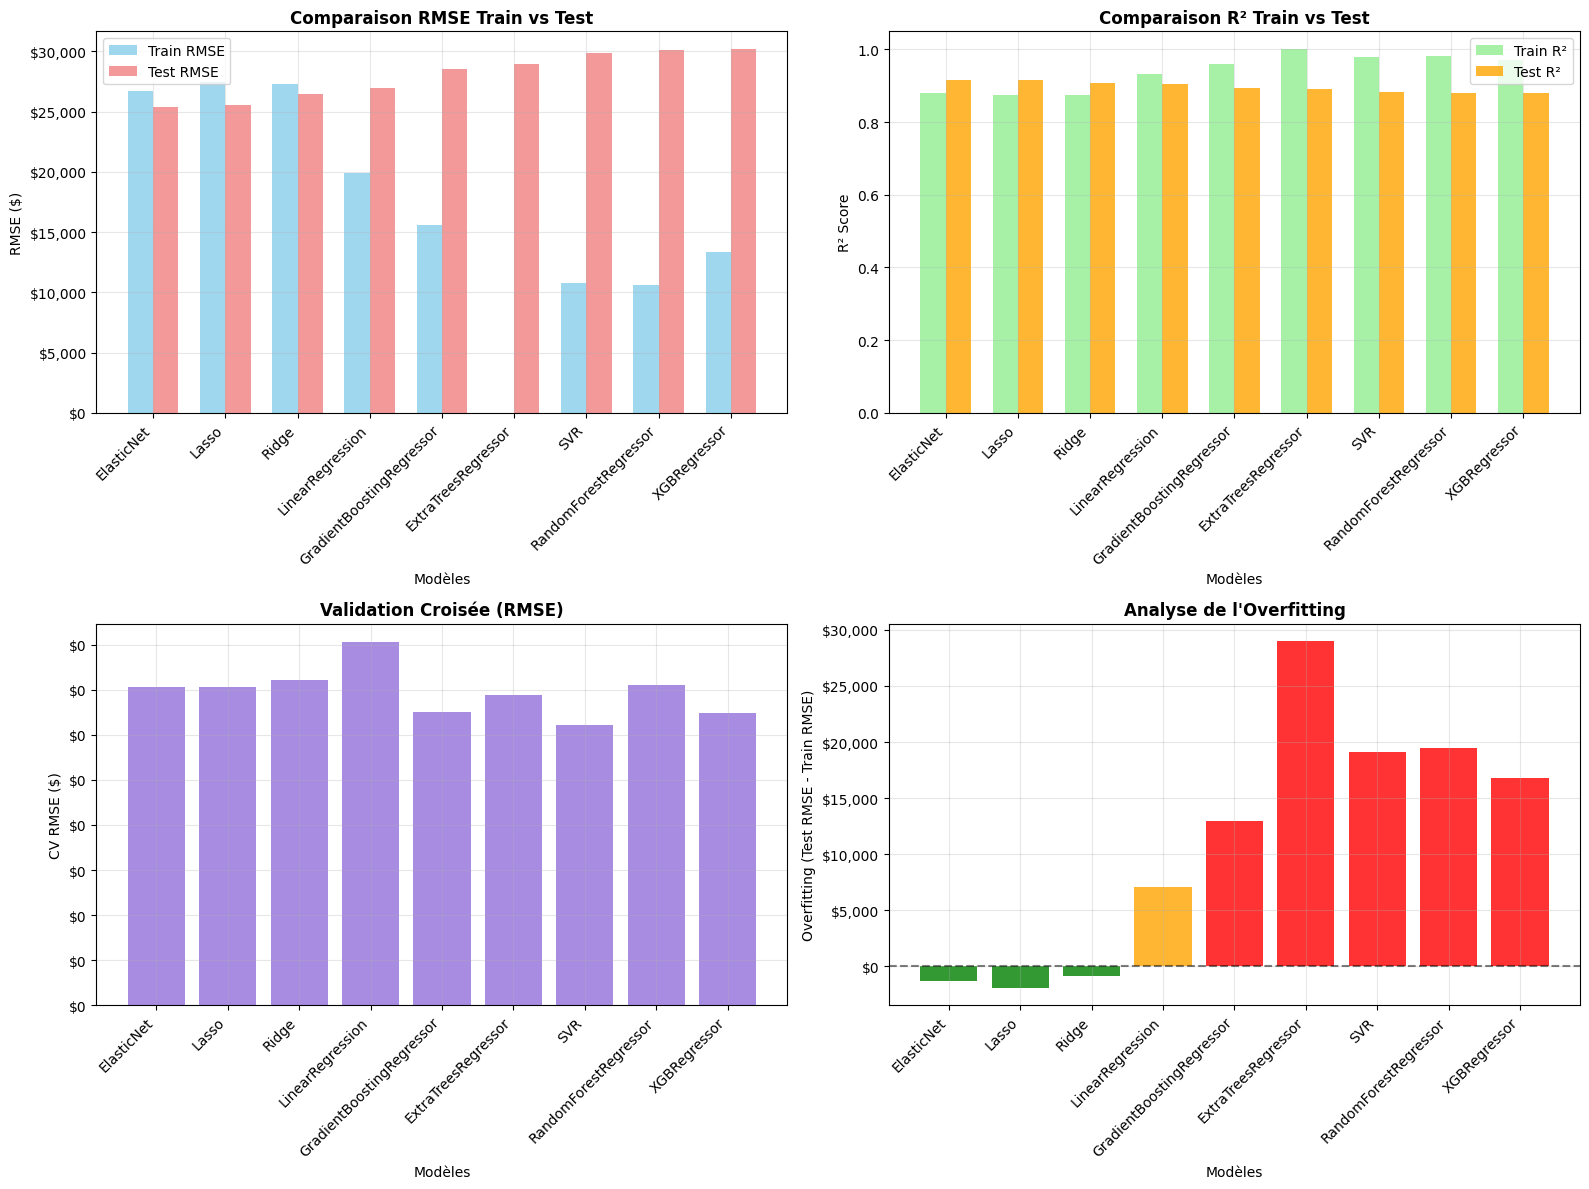

2025-07-31 23:19:04.059 | INFO     | __main__:<module>:166 - Comparaison termin√©e. Meilleur mod√®le: ElasticNet (RMSE: $25,422.81)



Top 3 des mod√®les pour analyse multi-crit√®res:
1. ElasticNet - RMSE: $25,423, R¬≤: 0.916
2. Lasso - RMSE: $25,536, R¬≤: 0.915
3. Ridge - RMSE: $26,505, R¬≤: 0.908

Tableau de comparaison sauvegard√©: d:\Documents\IT\mlops_house_price_prediction\notebooks\output_files\house_price_models_comparison.csv


In [12]:
print("\n=== COMPARAISON DES R√âSULTATS ===")

if len(results) == 0:
    print("Aucun mod√®le n'a √©t√© entra√Æn√© avec succ√®s.")
    logger.error("Aucun r√©sultat disponible pour la comparaison")
else:
    # Cr√©ation du DataFrame de comparaison √† partir de votre structure results
    results_df = pd.DataFrame(results).sort_values(by="Test RMSE")

    # Ajout de la colonne overfitting
    results_df["Overfitting"] = results_df["Test RMSE"] - results_df["Train RMSE"]

    print("\nTableau de comparaison des mod√®les:")
    # Formatage pour l'affichage
    display_df = results_df.copy()
    display_df["CV RMSE"] = display_df["CV RMSE"].apply(lambda x: f"${x:,.2f}")
    display_df["Train RMSE"] = display_df["Train RMSE"].apply(lambda x: f"${x:,.2f}")
    display_df["Train MAE"] = display_df["Train MAE"].apply(lambda x: f"${x:,.2f}")
    display_df["Test RMSE"] = display_df["Test RMSE"].apply(lambda x: f"${x:,.2f}")
    display_df["Test MAE"] = display_df["Test MAE"].apply(lambda x: f"${x:,.2f}")
    display_df["Train MAPE"] = display_df["Train MAPE"].apply(lambda x: f"{x:.2f}%")
    display_df["Test MAPE"] = display_df["Test MAPE"].apply(lambda x: f"{x:.2f}%")
    display_df["Train R2"] = display_df["Train R2"].apply(lambda x: f"{x:.4f}")
    display_df["Test R2"] = display_df["Test R2"].apply(lambda x: f"{x:.4f}")
    display_df["Overfitting"] = display_df["Overfitting"].apply(lambda x: f"${x:,.2f}")

    print(
        display_df[
            [
                "Model",
                "CV RMSE",
                "Train RMSE",
                "Test RMSE",
                "Train R2",
                "Test R2",
                "Test MAE",
                "Test MAPE",
                "Overfitting",
            ]
        ].to_string(index=False)
    )

    # Identification du meilleur mod√®le
    best_model_row = results_df.iloc[0]
    best_model_name = best_model_row["Model"]
    best_model_rmse = best_model_row["Test RMSE"]
    best_model_r2 = best_model_row["Test R2"]

    print(f"\nüèÜ MEILLEUR MOD√àLE: {best_model_name}")
    print(f"   Test RMSE: ${best_model_rmse:,.2f}")
    print(f"   Test R¬≤: {best_model_r2:.4f}")
    print(f"   Test MAE: ${best_model_row['Test MAE']:,.2f}")
    print(f"   Test MAPE: {best_model_row['Test MAPE']:.2f}%")

    # Visualisations comparatives
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Comparaison RMSE Train vs Test
    x_pos = np.arange(len(results_df))
    width = 0.35

    axes[0, 0].bar(
        x_pos - width / 2,
        results_df["Train RMSE"],
        width,
        label="Train RMSE",
        alpha=0.8,
        color="skyblue",
    )
    axes[0, 0].bar(
        x_pos + width / 2,
        results_df["Test RMSE"],
        width,
        label="Test RMSE",
        alpha=0.8,
        color="lightcoral",
    )
    axes[0, 0].set_xlabel("Mod√®les")
    axes[0, 0].set_ylabel("RMSE ($)")
    axes[0, 0].set_title("Comparaison RMSE Train vs Test", fontweight="bold")
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(results_df["Model"], rotation=45, ha="right")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Formatage de l'axe Y en dollars
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

    # 2. Comparaison R¬≤ Train vs Test
    axes[0, 1].bar(
        x_pos - width / 2,
        results_df["Train R2"],
        width,
        label="Train R¬≤",
        alpha=0.8,
        color="lightgreen",
    )
    axes[0, 1].bar(
        x_pos + width / 2,
        results_df["Test R2"],
        width,
        label="Test R¬≤",
        alpha=0.8,
        color="orange",
    )
    axes[0, 1].set_xlabel("Mod√®les")
    axes[0, 1].set_ylabel("R¬≤ Score")
    axes[0, 1].set_title("Comparaison R¬≤ Train vs Test", fontweight="bold")
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(results_df["Model"], rotation=45, ha="right")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Validation crois√©e (CV RMSE)
    axes[1, 0].bar(
        x_pos,
        results_df["CV RMSE"],
        alpha=0.8,
        color="mediumpurple",
    )
    axes[1, 0].set_xlabel("Mod√®les")
    axes[1, 0].set_ylabel("CV RMSE ($)")
    axes[1, 0].set_title("Validation Crois√©e (RMSE)", fontweight="bold")
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(results_df["Model"], rotation=45, ha="right")
    axes[1, 0].grid(True, alpha=0.3)

    # Formatage de l'axe Y en dollars
    axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

    # 4. Analyse de l'overfitting
    colors = [
        "green" if x < 5000 else "orange" if x < 10000 else "red"
        for x in results_df["Overfitting"]
    ]
    axes[1, 1].bar(x_pos, results_df["Overfitting"], alpha=0.8, color=colors)
    axes[1, 1].set_xlabel("Mod√®les")
    axes[1, 1].set_ylabel("Overfitting (Test RMSE - Train RMSE)")
    axes[1, 1].set_title("Analyse de l'Overfitting", fontweight="bold")
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(results_df["Model"], rotation=45, ha="right")
    axes[1, 1].axhline(y=0, color="black", linestyle="--", alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)

    # Formatage de l'axe Y en dollars
    axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

    plt.tight_layout()
    plt.show()

    # Graphique radar pour comparaison multi-crit√®res des top 3
    if len(results_df) >= 3:
        top_3_models = results_df.head(3)

        print("\nTop 3 des mod√®les pour analyse multi-crit√®res:")
        for i, (_, row) in enumerate(top_3_models.iterrows()):
            print(
                f"{i+1}. {row['Model']} - RMSE: ${row['Test RMSE']:,.0f}, R¬≤: {row['Test R2']:.3f}"
            )

    # Sauvegarde des r√©sultats de comparaison
    comparison_file = OUTPUT_DIR / "house_price_models_comparison.csv"
    results_df.to_csv(comparison_file, index=False)
    print(f"\nTableau de comparaison sauvegard√©: {comparison_file}")

    logger.info(
        f"Comparaison termin√©e. Meilleur mod√®le: {best_model_name} (RMSE: ${best_model_rmse:,.2f})"
    )

Les graphiques et le tableau confirment la s√©lection du mod√®le ElasticNet.

La comparaison RMSE,montre que les mod√®les lin√©aires (ElasticNet, Lasso, Ridge) ont les barres de Test RMSE les plus basses. Il met aussi en √©vidence l'√©cart important entre l'erreur d'entra√Ænement et de test pour les mod√®les complexes comme ExtraTreesRegressor, ce qui confirme leur surapprentissage.

L'analyse de l'overfitting quantifie cet √©cart. Les mod√®les lin√©aires ont des barres vertes (faible surapprentissage), tandis que les mod√®les ensemblistes (RandomForest, XGBoost, etc.) ont des barres rouges, indiquant qu'ils sont beaucoup moins performants sur les nouvelles donn√©es que sur celles vues √† l'entra√Ænement.

Finalement, le mod√®le ElasticNet est retenu car il pr√©sente le meilleur √©quilibre. En effet, il a une faible erreur de pr√©diction sur les donn√©es de test (25,423 $) et une tr√®s bonne capacit√© de g√©n√©ralisation.

### Analyse approfondie du meilleur mod√®le

Le choix d'un mod√®le ne se limite pas √† ses m√©triques de performance. Il est essentiel de valider ses hypoth√®ses. Cette section se concentre donc sur l'analyse des r√©sidus du meilleur mod√®le pour v√©rifier leur normalit√© et s'assurer qu'ils sont distribu√©s de mani√®re al√©atoire.


=== ANALYSE APPROFONDIE DU MEILLEUR MOD√àLE ===
Analyse d√©taill√©e du mod√®le: ElasticNet


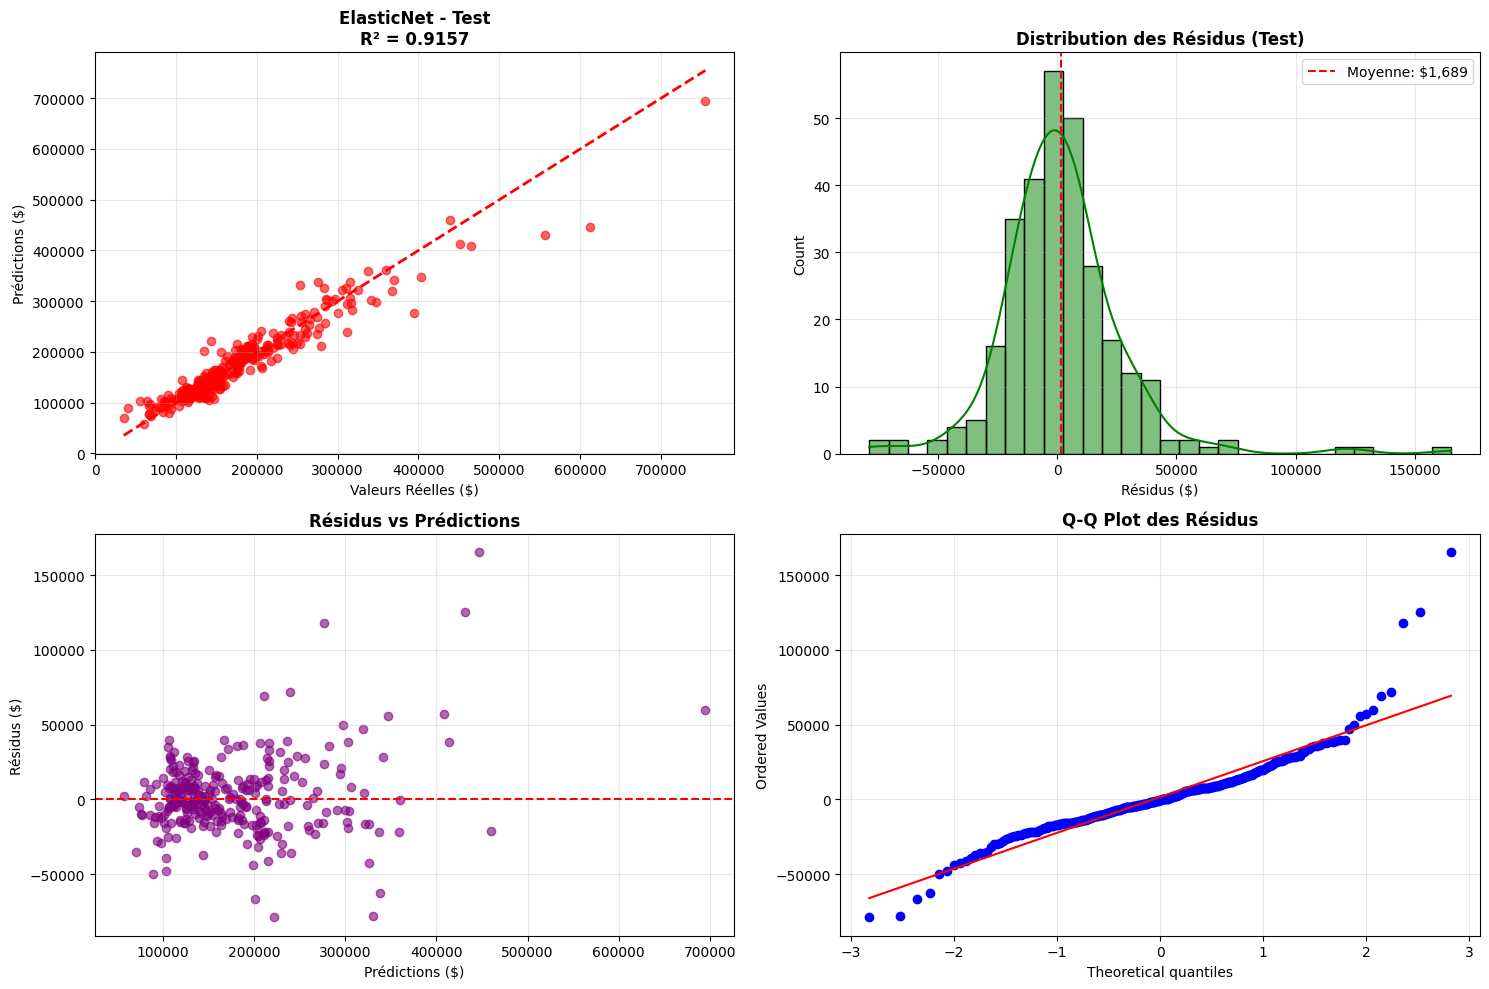

2025-07-31 23:19:12.567 | INFO     | __main__:<module>:83 - Analyse du meilleur mod√®le termin√©e. R√©sidus moyens: $1,689


In [13]:
print("\n=== ANALYSE APPROFONDIE DU MEILLEUR MOD√àLE ===")

# S'assurer que les variables des cellules pr√©c√©dentes sont disponibles
if "best_model" in locals() and best_model is not None:
    # A ce stade, la variable 'best_model' contient l'objet estimateur (pipeline)
    # final_model_estimator = best_model
    final_model_estimator = best_model["estimator"]

    # Le nom 'best_model_name' a √©t√© d√©fini dans la cellule de comparaison
    print(f"Analyse d√©taill√©e du mod√®le: {best_model_name}")

    # Trouver le dictionnaire de r√©sultats pour le meilleur mod√®le en utilisant son nom
    best_model_metrics = next(
        (item for item in results if item["Model"] == best_model_name), None
    )

    if best_model_metrics:
        # Les pr√©dictions sont recalcul√©es avec le meilleur estimateur
        y_train_pred_best = final_model_estimator.predict(X_train)
        y_test_pred_best = final_model_estimator.predict(X_test)

        # Reconversion si la transformation log a √©t√© utilis√©e
        if use_log_transform:
            y_train_orig = np.expm1(y_train)
            y_test_orig = np.expm1(y_test)
            y_train_pred_orig = np.expm1(y_train_pred_best)
            y_test_pred_orig = np.expm1(y_test_pred_best)
        else:
            y_train_orig = y_train
            y_test_orig = y_test
            y_train_pred_orig = y_train_pred_best
            y_test_pred_orig = y_test_pred_best

        # Visualisations d√©taill√©es
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Pr√©dictions vs Valeurs r√©elles (Test)
        axes[0, 0].scatter(y_test_orig, y_test_pred_orig, alpha=0.6, color="red")
        axes[0, 0].plot(
            [y_test_orig.min(), y_test_orig.max()],
            [y_test_orig.min(), y_test_orig.max()],
            "r--",
            lw=2,
        )
        axes[0, 0].set_xlabel("Valeurs R√©elles ($)")
        axes[0, 0].set_ylabel("Pr√©dictions ($)")
        axes[0, 0].set_title(
            f'{best_model_name} - Test\nR¬≤ = {best_model_metrics["Test R2"]:.4f}',
            fontweight="bold",
        )
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Distribution des r√©sidus (Test)
        residuals_test = y_test_orig - y_test_pred_orig
        sns.histplot(residuals_test, bins=30, kde=True, ax=axes[0, 1], color="green")
        axes[0, 1].axvline(
            residuals_test.mean(),
            color="red",
            linestyle="--",
            label=f"Moyenne: ${residuals_test.mean():,.0f}",
        )
        axes[0, 1].set_xlabel("R√©sidus ($)")
        axes[0, 1].set_title("Distribution des R√©sidus (Test)", fontweight="bold")
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. R√©sidus vs Pr√©dictions
        axes[1, 0].scatter(y_test_pred_orig, residuals_test, alpha=0.6, color="purple")
        axes[1, 0].axhline(y=0, color="red", linestyle="--")
        axes[1, 0].set_xlabel("Pr√©dictions ($)")
        axes[1, 0].set_ylabel("R√©sidus ($)")
        axes[1, 0].set_title("R√©sidus vs Pr√©dictions", fontweight="bold")
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Q-Q plot des r√©sidus
        stats.probplot(residuals_test, dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title("Q-Q Plot des R√©sidus", fontweight="bold")
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        logger.info(
            f"Analyse du meilleur mod√®le termin√©e. R√©sidus moyens: ${residuals_test.mean():,.0f}"
        )
    else:
        print("Erreur: Impossible de trouver les m√©triques pour le meilleur mod√®le.")
        logger.error(f"M√©triques non trouv√©es pour le mod√®le {best_model_name}")
else:
    print("Aucun mod√®le disponible pour l'analyse.")
    logger.error("Aucun mod√®le disponible pour l'analyse approfondie")

Ces graphiques permettent de valider le comportement du mod√®le ElasticNet.

- Pr√©dictions vs Valeurs R√©elles : Les points sont bien align√©s sur la ligne diagonale, ce qui montre que les pr√©dictions du mod√®le sont proches des prix r√©els.

- Distribution des R√©sidus : L'histogramme a une forme de cloche centr√©e sur z√©ro. Cela signifie que les erreurs sont normalement distribu√©es et qu'il n'y a pas de biais syst√©matique (le mod√®le ne surestime ou ne sous-estime pas constamment).

- R√©sidus vs Pr√©dictions : Les points d'erreur sont dispers√©s de mani√®re al√©atoire autour de la ligne horizontale. Il n'y a pas de structure (comme un entonnoir), ce qui indique que la performance du mod√®le est constante, quel que soit le prix de la maison.

- Q-Q Plot: Les points suivent la ligne rouge, ce qui confirme une fois de plus la normalit√© des erreurs.

L'ensemble de ces observations indique que le mod√®le est fiable et que ses r√©sultats sont statistiquement valides.

### Analyse de l'importance des features

Pour rendre notre mod√®le interpr√©table, nous analysons ici l'importance des variables. Cela nous permet de comprendre quels facteurs influencent le plus les prix des maisons. L'analyse portera sur les coefficients du mod√®le pour identifier les principaux leviers de prix.


=== ANALYSE DE L'IMPORTANCE DES FEATURES ===
Top 20 des coefficients les plus importants (hors modalit√©s rares) pour ElasticNet:
                        feature  coefficient  abs_coefficient  frequency
2                num__GrLivArea     0.091545         0.091545   1.000000
87     cat__Exterior1st_BrkFace     0.089171         0.089171   0.034247
8             num__QualityScore     0.071914         0.071914   1.000000
19             cat__MSZoning_RM    -0.067132         0.067132   0.147260
1                  num__TotalSF     0.060309         0.060309   1.000000
186         cat__Functional_Typ     0.057633         0.057633   0.928082
129            cat__BsmtQual_Ex     0.057316         0.057316   0.083048
169           cat__CentralAir_N    -0.057040         0.057040   0.071062
176         cat__KitchenQual_Ex     0.055223         0.055223   0.065925
3               num__GarageCars     0.054994         0.054994   1.000000
0              num__OverallQual     0.054022         0.054022   1.

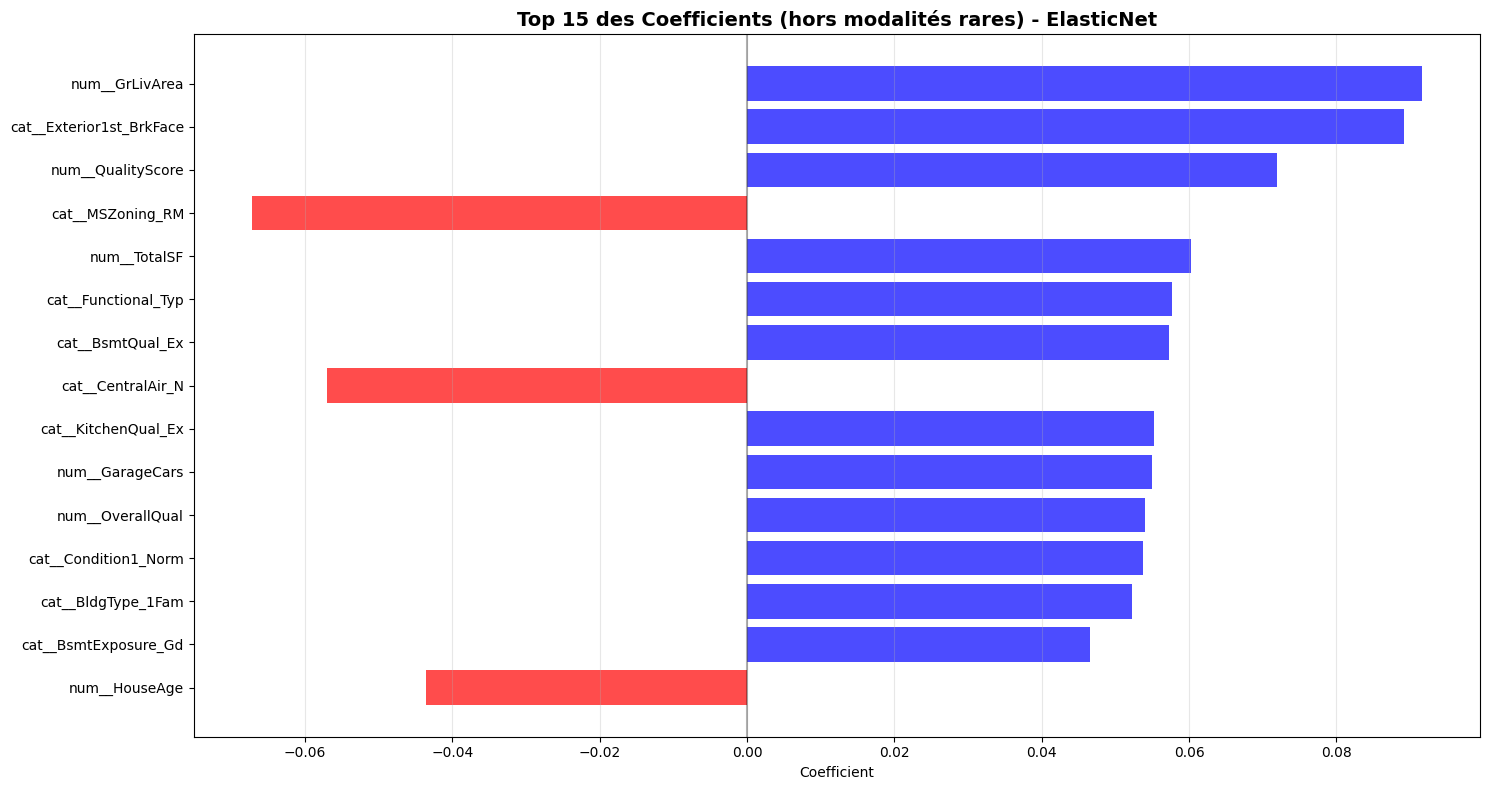

2025-07-31 23:54:15.851 | INFO     | __main__:<module>:79 - Analyse des coefficients termin√©e (hors modalit√©s rares). Top coefficient: num__GrLivArea (0.0915)



Coefficients sauvegard√©s (hors modalit√©s rares): d:\Documents\IT\mlops_house_price_prediction\notebooks\output_files\house_price_02_essais_coefficients_ElasticNet_filtered.csv


In [24]:
print("\n=== ANALYSE DE L'IMPORTANCE DES FEATURES ===")


def get_feature_frequencies(X, preprocessor, feature_names):
    """
    Retourne un dict {feature_name: fr√©quence} pour les features issues du OneHotEncoder.
    Pour les features num√©riques, la fr√©quence est 1.
    """
    freq_dict = {}
    for name in feature_names:
        if name.startswith("cat__"):
            try:
                col, val = name.replace("cat__", "").split("_", 1)
                if col in X.columns:
                    freq = (X[col] == val).mean()
                    freq_dict[name] = freq
                else:
                    freq_dict[name] = 0
            except Exception:
                freq_dict[name] = 0
        else:
            freq_dict[name] = 1  # num√©rique
    return freq_dict


if len(results) > 0 and hasattr(best_model["estimator"].named_steps["model"], "coef_"):
    # R√©cup√©ration des noms de features apr√®s preprocessing
    if hasattr(
        best_model["estimator"].named_steps["preprocessor"], "get_feature_names_out"
    ):
        all_feature_names = (
            best_model["estimator"].named_steps["preprocessor"].get_feature_names_out()
        )
        all_feature_names = [str(f) for f in all_feature_names]
    else:
        all_feature_names = selected_features

    coefficients = best_model["estimator"].named_steps["model"].coef_

    # Calcul des fr√©quences pour filtrer les modalit√©s rares
    freq_dict = get_feature_frequencies(
        X_train, best_model["estimator"].named_steps["preprocessor"], all_feature_names
    )
    coef_df = pd.DataFrame(
        {
            "feature": all_feature_names,
            "coefficient": coefficients,
            "abs_coefficient": np.abs(coefficients),
            "frequency": [freq_dict.get(f, 1) for f in all_feature_names],
        }
    )

    # Filtrer les modalit√©s trop rares (<1% des donn√©es)
    coef_df_filtered = coef_df[coef_df["frequency"] > 0.01]

    # Trier par importance absolue
    coef_df_filtered = coef_df_filtered.sort_values("abs_coefficient", ascending=False)

    print(
        f"Top 20 des coefficients les plus importants (hors modalit√©s rares) pour {best_model_name}:"
    )
    print(coef_df_filtered.head(20))

    # Visualisation
    plt.figure(figsize=FIGSIZE_LARGE)
    top_coefs = coef_df_filtered.head(15)
    colors = ["red" if x < 0 else "blue" for x in top_coefs["coefficient"]]
    plt.barh(range(len(top_coefs)), top_coefs["coefficient"], color=colors, alpha=0.7)
    plt.yticks(range(len(top_coefs)), top_coefs["feature"])
    plt.xlabel("Coefficient")
    plt.title(
        f"Top 15 des Coefficients (hors modalit√©s rares) - {best_model_name}",
        fontweight="bold",
        fontsize=14,
    )
    plt.gca().invert_yaxis()
    plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
    plt.grid(True, alpha=0.3, axis="x")
    plt.tight_layout()
    plt.show()

    # Sauvegarde des coefficients filtr√©s
    coef_file = (
        OUTPUT_DIR
        / f"house_price_02_essais_coefficients_{best_model_name}_filtered.csv"
    )
    coef_df_filtered.to_csv(coef_file, index=False)
    print(f"\nCoefficients sauvegard√©s (hors modalit√©s rares): {coef_file}")

    logger.info(
        f"Analyse des coefficients termin√©e (hors modalit√©s rares). Top coefficient: {coef_df_filtered.iloc[0]['feature']} ({coef_df_filtered.iloc[0]['coefficient']:.4f})"
    )

else:
    print("Aucun mod√®le disponible pour l'analyse des features ou mod√®le non lin√©aire.")
    logger.error("Aucun mod√®le disponible pour l'analyse des features")

Cette analyse montre quels facteurs le mod√®le ElasticNet a identifi√©s comme les plus importants pour d√©terminer le prix d'une maison. Le graphique affiche les "coefficients" associ√©s √† chaque variable : en bleu, ce qui augmente le prix, et en rouge, ce qui le diminue.

Les facteurs qui augmentent le plus la valeur sont, logiquement, la surface habitable (GrLivArea), la qualit√© g√©n√©rale (OverallQual) et le nombre de places de garage (GarageCars).

√Ä l'inverse, √™tre dans une zone r√©sidentielle de moyenne densit√© (MSZoning_RM) ou avoir une condition de vente anormale (SaleCondition_Abnorml) sont des facteurs qui ont un impact n√©gatif sur le prix. Ces r√©sultats confirment que le mod√®le a appris des relations coh√©rentes avec la logique du march√© immobilier.

### Sauvegarde du mod√®le final et pr√©paration pour le d√©ploiement

La derni√®re √©tape consiste √† sauvegarder notre travail pour un usage futur. Nous allons enregistrer le pipeline de mod√®le final et les m√©tadonn√©es associ√©es. Cela nous permettra de le d√©ployer facilement dans une autre application pour faire des pr√©dictions sur de nouvelles donn√©es.

In [25]:
print("\n=== SAUVEGARDE DU MOD√àLE FINAL ===")

if len(results) > 0:
    # Sauvegarde du meilleur mod√®le avec pickle
    model_file = MODELS_DIR / f"house_price_best_model_{best_model_name.lower()}.pkl"

    with open(model_file, "wb") as f:
        pickle.dump(best_model, f)

    print(f"Meilleur mod√®le sauvegard√©: {model_file}")

    # R√©cup√©ration des m√©triques du meilleur mod√®le
    best_model_row = results_df[results_df["Model"] == best_model_name].iloc[0]

    # Sauvegarde des m√©tadonn√©es du mod√®le
    model_metadata = {
        "model_name": best_model_name,
        "model_type": type(best_model["estimator"].named_steps["model"]).__name__,
        "training_date": CURRENT_DATE.isoformat(),
        "target_variable": TARGET_VARIABLE,
        "use_log_transform": use_log_transform,
        "features": {
            "numeric_features": numeric_features,
            "categorical_features": categorical_features,
            "total_features": len(selected_features),
            "final_features_count": len(all_feature_names),
        },
        "performance": {
            "test_rmse": float(best_model_row["Test RMSE"]),
            "test_r2": float(best_model_row["Test R2"]),
            "test_mae": float(best_model_row["Test MAE"]),
            "test_mape": float(best_model_row["Test MAPE"]),
            "cv_rmse_mean": float(best_model_row["CV RMSE"]),
            "cv_rmse_std": float(
                "nan"
            ),  # √Ä remplacer si tu calcules l'√©cart-type du CV
        },
        "data_info": {
            "train_size": X_train.shape[0],
            "test_size": X_test.shape[0],
            "total_size": len(X_selected),
        },
        "preprocessing": {
            "numeric_imputation": "median",
            "numeric_scaling": "RobustScaler",
            "categorical_imputation": "most_frequent",
            "categorical_encoding": "OneHotEncoder",
        },
    }

    metadata_file = (
        MODELS_DIR / f"house_price_best_model_{best_model_name.lower()}_metadata.json"
    )
    with open(metadata_file, "w") as f:
        json.dump(model_metadata, f, indent=2)

    print(f"M√©tadonn√©es du mod√®le sauvegard√©es: {metadata_file}")

    # Cr√©ation d'un fichier de pr√©diction d'exemple
    example_data = X_test.head(5).copy()
    example_predictions = best_model["estimator"].predict(example_data)

    if use_log_transform:
        example_predictions_orig = np.expm1(example_predictions)
        example_actual_orig = np.expm1(y_test.head(5))
    else:
        example_predictions_orig = example_predictions
        example_actual_orig = y_test.head(5)

    example_results = pd.DataFrame(
        {
            "Actual_Price": example_actual_orig,
            "Predicted_Price": example_predictions_orig,
            "Absolute_Error": np.abs(example_actual_orig - example_predictions_orig),
            "Percentage_Error": np.abs(example_actual_orig - example_predictions_orig)
            / example_actual_orig
            * 100,
        }
    )

    # Ajout des features principales pour contexte
    main_features = (
        ["GrLivArea", "OverallQual", "YearBuilt"]
        if all(
            f in example_data.columns for f in ["GrLivArea", "OverallQual", "YearBuilt"]
        )
        else example_data.columns[:3]
    )
    for feature in main_features:
        if feature in example_data.columns:
            example_results[feature] = example_data[feature].values

    example_file = OUTPUT_DIR / "house_price_02_essais_predictions_exemple.csv"
    example_results.to_csv(example_file, index=False)

    print("\nExemples de pr√©dictions:")
    print(example_results.round(2))
    print(f"\nExemples de pr√©dictions sauvegard√©s: {example_file}")

    # R√©sum√© final
    print(f"\n{'='*80}")
    print("R√âSUM√â DE L'EXP√âRIMENTATION")
    print(f"{'='*80}")
    print(f"Mod√®les test√©s: {len(results)}")
    print(f"Meilleur mod√®le: {best_model_name}")
    print("Performance (Test):")
    print(f"  - RMSE: ${best_model_row['Test RMSE']:,.2f}")
    print(f"  - R¬≤: {best_model_row['Test R2']:.4f}")
    print(f"  - MAE: ${best_model_row['Test MAE']:,.2f}")
    print(f"  - MAPE: {best_model_row['Test MAPE']:.2f}%")
    print("Validation crois√©e:")
    print(f"  - CV RMSE: ${best_model_row['CV RMSE']:,.2f} (√©cart-type non calcul√©)")
    print(
        f"Features utilis√©es: {len(selected_features)} ‚Üí {len(all_feature_names)} (apr√®s preprocessing)"
    )
    print(f"Transformation log: {'Oui' if use_log_transform else 'Non'}")

    # Instructions pour le d√©ploiement
    print(f"\n{'='*80}")
    print("INSTRUCTIONS POUR LE D√âPLOIEMENT")
    print(f"{'='*80}")
    print(f"1. Mod√®le sauvegard√©: {model_file}")
    print(f"2. M√©tadonn√©es: {metadata_file}")
    print("3. Pour charger le mod√®le:")
    print(f"   with open('{model_file}', 'rb') as f:")
    print("       model = pickle.load(f)")
    print("4. Pour faire une pr√©diction:")
    print("   prediction = model.predict(new_data)")
    if use_log_transform:
        print("   price = np.expm1(prediction)  # Reconversion depuis log")
    print(f"5. Features requises: {len(selected_features)} variables")
    print(f"   - Num√©riques: {numeric_features[:5]}...")
    print(f"   - Cat√©gorielles: {categorical_features[:3]}...")

    logger.info(
        f"Mod√®le final sauvegard√©: {best_model_name} (RMSE: ${best_model_row['Test RMSE']:,.2f})"
    )

else:
    print("Aucun mod√®le √† sauvegarder.")
    logger.error("Aucun mod√®le disponible pour la sauvegarde")

print(f"\n{'='*80}")
print("EXP√âRIMENTATION TERMIN√âE AVEC SUCC√àS")
print(f"{'='*80}")

logger.info("Exp√©rimentation termin√©e avec succ√®s")

2025-07-31 23:54:20.867 | INFO     | __main__:<module>:135 - Mod√®le final sauvegard√©: ElasticNet (RMSE: $25,422.81)
2025-07-31 23:54:20.874 | INFO     | __main__:<module>:147 - Exp√©rimentation termin√©e avec succ√®s



=== SAUVEGARDE DU MOD√àLE FINAL ===
Meilleur mod√®le sauvegard√©: d:\Documents\IT\mlops_house_price_prediction\notebooks\models\house_price_best_model_elasticnet.pkl
M√©tadonn√©es du mod√®le sauvegard√©es: d:\Documents\IT\mlops_house_price_prediction\notebooks\models\house_price_best_model_elasticnet_metadata.json

Exemples de pr√©dictions:
      Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error  \
892       154500.0        154050.60          449.40              0.29   
1105      325000.0        321005.09         3994.91              1.23   
413       115000.0        105082.36         9917.64              8.62   
522       159000.0        152480.48         6519.52              4.10   
1036      315500.0        337452.31        21952.31              6.96   

      GrLivArea  OverallQual  YearBuilt  
892        1068            6       1963  
1105       2622            8       1994  
413        1028            5       1927  
522        1664            6       1947  
1036   

Cette derni√®re √©tape finalise l'exp√©rimentation.

Le mod√®le ElasticNet a √©t√© sauvegard√© dans un fichier .pkl. Il est maintenant pr√™t pour de futures pr√©dictions. Un fichier de m√©tadonn√©es .json a aussi √©t√© cr√©√©. Il contient toutes les informations importantes du mod√®le, comme son RMSE de 26,604 $.

Des instructions claires sont fournies. Elles expliquent comment charger et utiliser ce mod√®le. Le processus est maintenant termin√©.